# 📌 Specifiche del progetto

Creare un modello in grado di prevedere se un passeggero del Titanic sarebbe sopravvissuto o meno al tragico naufragio, in base a caratteristiche come età, sesso, classe di viaggio e altre variabili disponibili nel dataset. <br>
Modello di machine learning da utilizzare: Decision Tree Classifier<br>
Metrica di valutazione: Accuratezza<br><br>
Procedo all'importazione delle librerie.

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, make_scorer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Analisi ed esplorazione dati (EDA)

In [73]:
#Importazione e creazione del dataframe
url= 'https://drive.google.com/uc?export=download&id=18dmZtiPtM5hFmebUITjZb4uxVa52eTHH'
importazione = pd.read_csv(url)

titanic = pd.DataFrame(importazione)

titanic.head()

,PassengerId,Sex,Age,Pclass,Embarked,Survived
0,1,male,22.0,3,S,0
1,2,female,38.0,1,C,1
2,3,female,26.0,3,S,1
3,4,female,35.0,1,S,1
4,5,male,35.0,3,S,0


In [75]:
#Decido di impostare come indice PassengerId, in modo da rimuovere la colonna dell'indice automatica 
titanic = titanic.reset_index(drop=True)
titanic = titanic.set_index("PassengerId")
titanic.head()

,Sex,Age,Pclass,Embarked,Survived
PassengerId,,,,,
1,male,22.0,3,S,0
2,female,38.0,1,C,1
3,female,26.0,3,S,1
4,female,35.0,1,S,1
5,male,35.0,3,S,0


In [266]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex       891 non-null    object 
 1   Age       714 non-null    float64
 2   Pclass    891 non-null    int64  
 3   Embarked  889 non-null    object 
 4   Survived  891 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 41.8+ KB


I datatypes corrispondono alla tipologia di dato in ogni colonna.<br>
Ci sono 2 colonne di tipo object che quindi richiederanno di essere trasformate da dati categorici a dati numerici.<br>
Dai conteggi complessivi deduco che in alcune colonne ci sono valori null.

In [13]:
#Controllo dove ci sono i valori null
titanic.isnull().sum()

Sex           0
Age         177
Pclass        0
Embarked      2
Survived      0
dtype: int64

I valori nulli delle colonne Age ed Embarked verranno quindi elaborati nella fase di Preprocessing.<br>
#### Procedo al calcolo delle percentuali dei passeggeri sopravvissuti e non.

Totale Passeggeri: 891
Non Sopravvissuti: 549 (61.6%)
Sopravvissuti: 342 (38.4%)


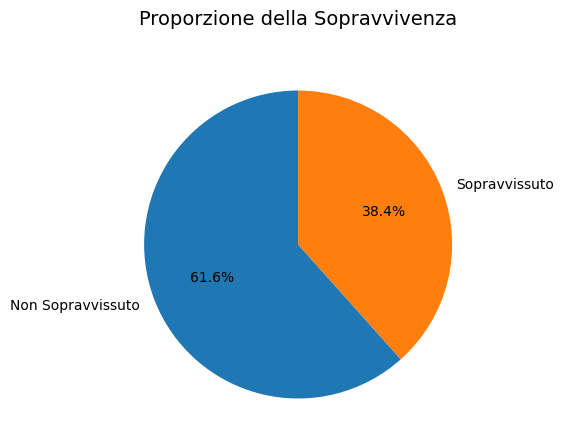

In [27]:
# Calcolo percentuali
survival_counts = titanic['Survived'].value_counts()
survival_percentages = survival_counts / len(titanic) * 100
labels = ['Non Sopravvissuto', 'Sopravvissuto']

total_passengers = len(titanic)

print(f"Totale Passeggeri: {len(titanic)}")
print(f"Non Sopravvissuti: {survival_counts[0]} ({survival_percentages[0]:.1f}%)")
print(f"Sopravvissuti: {survival_counts[1]} ({survival_percentages[1]:.1f}%)")

# PIE CHART 
plt.figure(figsize=(5, 5))
plt.pie(survival_counts.values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Proporzione della Sopravvivenza', fontsize=14, pad=20)
plt.show()

I passeggeri <b>non sopravvissuti sono di più di quelli sopravvissuti</b> (altrimenti quella del titanic non sarebbe stata la tragedia nota a tutti noi).<br>
#### Metto a confronto le colonne con le matrici di correlazione.

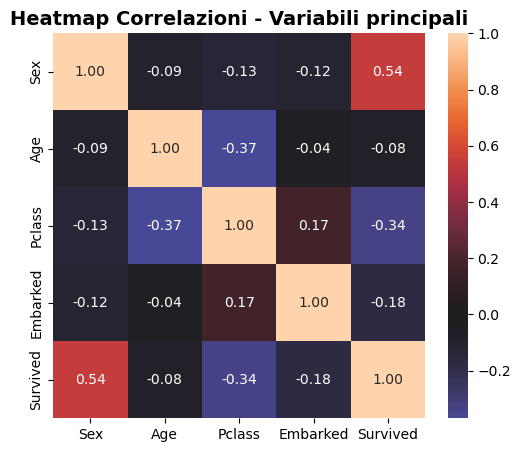

In [158]:
# Copia dei dati 
titanic_corr = titanic[['Sex', 'Age', 'Pclass', 'Embarked', 'Survived']].copy() 

# Converto le variabili categoriche in numeriche 
titanic_corr['Sex'] = titanic_corr['Sex'].map({'male':0, 'female':1})
titanic_corr['Embarked'] = titanic_corr['Embarked'].astype('category').cat.codes 

#Calcolo la matrice di correlazione 
corr_matrix = titanic_corr.corr() 

# Heatmap 
plt.figure(figsize=(6,5)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", center=0) 
plt.title("Heatmap Correlazioni - Variabili principali", fontsize=14, fontweight='bold') 
plt.show()

La correlazione più forte emerge tra Sesso (Sex) e Sopravvivenza (Survived) con un coefficiente di 0.54, mostrando <b>l'effetto determinante del genere sulla probabilità di salvezza</b>, coerente con la regola dell'epoca di salvare "prima donne e bambini".<br>
La correlazione dell'Età (Age) più significativa è quella negativa con la Classe (-0.37), indicando che passeggeri più anziani tendevano a viaggiare in classi superiori.<br>
La Classe (Pclass) mostra una correlazione negativa con la Sopravvivenza (-0.34), confermando che classi numericamente più basse (prima e seconda) avevano maggiori probabilità di salvezza.<br>
La correlazione positiva tra Classe ed Embarked (0.17) riflette una certa stratificazione sociale per porto d'imbarco, offrendoci dettagli socio-demografici aggiuntivi.<br><br>
<b><i>Le correlazioni più deboli (intorno a ±0.1-0.2) tra le altre variabili indicano relazioni presenti ma non dominanti, suggerendo che genere e classe sociale sono stati i fattori determinanti della sopravvivenza, mentre età e porto d'imbarco giocarono ruoli complementari ma meno determinanti.</b></i><br>
#### Procedo quindi ad analizzare più a fondo le tipologie di passeggeri (sopravvissuti e non) in base al genere e classe di imbarco.

Percentuale di sopravvivenza per Genere:
 Survived          0          1
Sex                           
female    25.796178  74.203822
male      81.109185  18.890815

Percentuale di sopravvivenza per Classe:
 Survived          0          1
Pclass                        
1         37.037037  62.962963
2         52.717391  47.282609
3         75.763747  24.236253


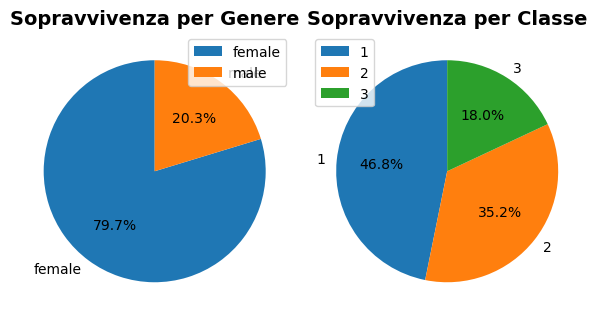

In [449]:
# Conteggi
sex_counts = titanic.groupby(['Sex', 'Survived']).size().unstack(fill_value=0) #trasforma i Survived in colonne (0 = no, 1 = sì)
class_counts = titanic.groupby(['Pclass', 'Survived']).size().unstack(fill_value=0)

# Percentuali
sex_percent = sex_counts.div(sex_counts.sum(axis=1), axis=0) * 100
class_percent = class_counts.div(class_counts.sum(axis=1), axis=0) * 100

print("Percentuale di sopravvivenza per Genere:\n", sex_percent)
print("\nPercentuale di sopravvivenza per Classe:\n", class_percent)

# Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6))

# Sopravvivenza per Sesso
sex_percent.plot(kind='pie', y=1, labels=sex_percent.index, autopct='%1.1f%%', ax=ax1, startangle=90)
ax1.set_ylabel('') #serve a nascondere il numero 1 del valore booleano
ax1.set_title('Sopravvivenza per Genere', fontsize=14, fontweight='bold')

# Sopravvivenza per Classe
class_percent.plot(kind='pie', y=1, labels=class_percent.index, autopct='%1.1f%%', ax=ax2, startangle=90)
ax2.set_ylabel('')
ax2.set_title('Sopravvivenza per Classe', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

È evidente che, in base alle regole di evacuazione che davano priorità a donne e bambini sulle scialuppe di salvataggio, <b>le donne si siano salvate di più degli uomini</b>.<br>
Il secondo grafico mostra come invece fattori sociali e strutturali abbiano inciso sulle possibilità di salvarsi: <b>i passeggeri della prima classe sono quelli che si sono salvati più di tutti</b>, in quanto localizzati anche in stanze più vicine alle scialuppe di salvataggio e con facile accesso alle vie di evacuazione.<br>
#### Passo all'analisi dei sopravvissuti in base all'età.

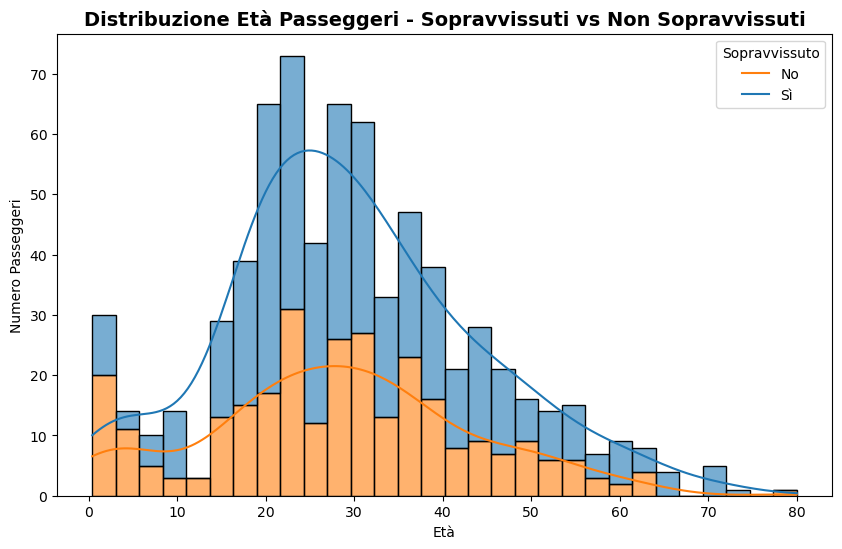

In [334]:
# Rimuovo valori mancanti per i calcoli
titanic_age = titanic.dropna(subset=['Age'])

# Grafico a istogramma sovrapposto
plt.figure(figsize=(10,6))
sns.histplot(data=titanic_age, x='Age', hue='Survived', multiple='stack',
             edgecolor='black', kde=True, bins=30, alpha=0.6)

plt.title('Distribuzione Età Passeggeri - Sopravvissuti vs Non Sopravvissuti', fontsize=14, fontweight='bold')
plt.xlabel('Età')
plt.ylabel('Numero Passeggeri')
plt.legend(title='Sopravvissuto', labels=['No', 'Sì'])

plt.show()

Questo grafico mostra come la distribuzione dei non sopravvissuti sia stabile in tutte le fasce d'età (dopotutto coloro che riuscirono a salvarsi sono soltanto una minoranza, appena il 38%).<br>
A essere sopravvissuti pero' è stata soprattutto la fascia d'età tra i 20 e 40 anni, con un picco intorno ai 25 anni.

In [94]:
import scipy
from scipy import stats

# Statistiche dettagliate
print("\n ETÀ PER CLASSE PASSEGGERI:")
pclass_simple_stats = titanic.groupby('Pclass')['Age'].agg(['count', 'mean', 'median', 'std'])
for pclass, stats in pclass_simple_stats.iterrows():
    print(f"  Classe {int(pclass)}: n={int(stats['count'])}, "
          f"Media={stats['mean']:.2f}, "
          f"Mediana={stats['median']:.2f}, "
          f"Dev.std={stats['std']:.2f}")

print("\n ETÀ PER GENERE:")
sex_simple_stats = titanic.groupby('Sex')['Age'].agg(['count', 'mean', 'median', 'std'])
for sex, stats in sex_simple_stats.iterrows():
    print(f"  {sex.capitalize()}: n={int(stats['count'])}, "
          f"Media={stats['mean']:.2f}, "
          f"Mediana={stats['median']:.2f}, "
          f"Dev.std={stats['std']:.2f}")

print("\nETÀ PER CLASSE E GENERE:")
combined_stats = titanic.groupby(['Pclass', 'Sex'])['Age'].agg(['mean', 'median', 'count']).round(2)
for (pclass, sex), stats in combined_stats.iterrows():
    print(f"  Classe {int(pclass)} - {sex.capitalize()}: "
          f"Media={stats['mean']:.2f}, "
          f"Mediana={stats['median']:.2f}, "
          f"n={int(stats['count'])}")

print(f"\nDati basati su {len(titanic)} passeggeri con età nota su {len(titanic)} totali")


 ETÀ PER CLASSE PASSEGGERI:
  Classe 1: n=186, Media=38.23, Mediana=37.00, Dev.std=14.80
  Classe 2: n=173, Media=29.88, Mediana=29.00, Dev.std=14.00
  Classe 3: n=355, Media=25.14, Mediana=24.00, Dev.std=12.50

 ETÀ PER GENERE:
  Female: n=261, Media=27.92, Mediana=27.00, Dev.std=14.11
  Male: n=453, Media=30.73, Mediana=29.00, Dev.std=14.68

ETÀ PER CLASSE E GENERE:
  Classe 1 - Female: Media=34.61, Mediana=35.00, n=85
  Classe 1 - Male: Media=41.28, Mediana=40.00, n=101
  Classe 2 - Female: Media=28.72, Mediana=28.00, n=74
  Classe 2 - Male: Media=30.74, Mediana=30.00, n=99
  Classe 3 - Female: Media=21.75, Mediana=21.50, n=102
  Classe 3 - Male: Media=26.51, Mediana=25.00, n=253

Dati basati su 891 passeggeri con età nota su 891 totali


L'analisi della distribuzione dell'età rivela pattern legati allo status socio-economico dei passeggeri. La prima classe ha un'età media superiore della seconda e terza, con una distribuzione dei valori non troppo asimmetrica stando alla deviazione standard. Questo riflette la correlazione tra età e stabilità economica, con le classi superiori caratterizzate da passeggeri adulti e la terza classe dominata da giovani emigranti.

La distribuzione per genere mostra differenze modeste nell'età media, ma nella distribuzione per classe e genere ci sono alcune differenze marcate: in prima classe gli uomini sono più anziani, mentre in terza classe la popolazione femminile è più giovane.

# 📌 Preprocessing dei dati

Ora posso separare il target "Survived" dalle altre features.

In [77]:
# Colonne
numeric_features = ["Age", "Pclass"]
categorical_features = ["Sex", "Embarked"]

X = titanic.drop(columns="Survived")
y = titanic["Survived"]

print(X.shape, y.shape)

(891, 4) (891,)


Procedo a dividere features e target in train (75%) e test (25%) set.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(668, 4)
(223, 4)
(668,)
(223,)


Separo ulteriormente il train set in due sottoinsiemi, per avere un set train e un set di validation.

In [81]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

print(X_train_sub.shape)
print(X_val.shape)
print(y_train_sub.shape)
print(y_val.shape)

(501, 4)
(167, 4)
(501,)
(167,)


#### Sostituzione valori nulli colonna Embarked.<br>
Trattandosi di una colonna con dati categorici, la statistica suggerisce di ricorrere alla moda nella sostituzione dei valori nulli in quanto valore più frequente e più rappresentativo che meglio si adatta ai valori categorici. Trattandosi pero' di soli 2 valori nulli, faccio un'analisi comparativa tra queste due opzioni:
1. Sostituzione con la moda
2. Eliminazione dei due valori null

Procedura:
- Definisco due ColumnTransformer:
A) Sostituzione valori nulli con la moda
B) Eliminazione valori nulli
- Creo una Pipeline (preprocess -> model).
- Con GridSearchCV confronto A vs B e cerco max_depth del Decision Tree (incluso None).
- Valuto con macro-F1 usando una StratifiedKFold, poi stimo la performance sul test set.

In [83]:
# --- Scenario A: imputazione con la moda ---
embarked_A = ColumnTransformer(
    transformers=[
        ("Sex", OneHotEncoder(handle_unknown="ignore"), ["Sex"]),
        ("Embarked", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), ["Embarked"])
    ],
    remainder="passthrough"   # colonne numeriche restano invariate
)

# --- Scenario B: eliminazione delle righe con NaN ---
# In questo scenario, prepariamo il dataset a monte.
# Per garantire il corretto funzionamento, applichiamo la maschera al training set prima di passarlo a GridSearchCV.
mask_train_B = X_train["Embarked"].notna()
X_train_B = X_train[mask_train_B]
y_train_B = y_train[mask_train_B]

embarked_B = ColumnTransformer(
    transformers=[
        ("Sex", OneHotEncoder(handle_unknown="ignore"), ["Sex"]),
        ("Embarked", OneHotEncoder(handle_unknown="ignore"), ["Embarked"])
    ],
    remainder="passthrough"
)

# === PIPELINE + MODELLO BASELINE ===
pipe_A = Pipeline(steps=[
    ("preprocess", embarked_A),
    ("model", DecisionTreeClassifier(random_state=0)),
])

pipe_B = Pipeline(steps=[
    ("preprocess", embarked_B),
    ("model", DecisionTreeClassifier(random_state=0)),
])

# === CONFRONTO A E B ===
# Utilizzo due pipeline separate, una per ogni scenario.
# Questo è il modo corretto per confrontare due diversi processi di preprocessing che richiedono input diversi.
param_grid_A = {
    "model__max_depth": [None, 2, 5, 10, 25],
}

param_grid_B = {
    "model__max_depth": [None, 2, 5, 10, 25],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Eseguo GridSearchCV separatamente per ogni scenario
grid_A = GridSearchCV(
    estimator=pipe_A,
    param_grid=param_grid_A,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
grid_A.fit(X_train, y_train)

grid_B = GridSearchCV(
    estimator=pipe_B,
    param_grid=param_grid_B,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
grid_B.fit(X_train_B, y_train_B)

print("--- Scenario A (Imputazione) ---")
print("Migliori parametri:", grid_A.best_params_)
print("Miglior macro-F1 (CV):", round(grid_A.best_score_, 4))

print("\n--- Scenario B (Eliminazione) ---")
print("Migliori parametri:", grid_B.best_params_)
print("Miglior macro-F1 (CV):", round(grid_B.best_score_, 4))

# === VALUTAZIONE SU TEST SET ===
# Decidiamo il miglior modello tra i due scenari
if grid_A.best_score_ > grid_B.best_score_:
    best_model = grid_A.best_estimator_
    print("\nIl modello migliore è quello dello Scenario A (Imputazione).")
else:
    best_model = grid_B.best_estimator_
    print("\nIl modello migliore è quello dello Scenario B (Eliminazione).")

# Valutazione finale sul test set
y_pred = best_model.predict(X_test)

print("\nMacro-F1 (test):", round(f1_score(y_test, y_pred, average="macro"), 4))
print("\nClassification report (test):\n")
print(classification_report(y_test, y_pred, digits=3))

--- Scenario A (Imputazione) ---
Migliori parametri: {'model__max_depth': 10}
Miglior macro-F1 (CV): 0.7804

--- Scenario B (Eliminazione) ---
Migliori parametri: {'model__max_depth': 10}
Miglior macro-F1 (CV): 0.7822

Il modello migliore è quello dello Scenario B (Eliminazione).

Macro-F1 (test): 0.7577

Classification report (test):

              precision    recall  f1-score   support

           0      0.807     0.842     0.824       139
           1      0.718     0.667     0.691        84

    accuracy                          0.776       223
   macro avg      0.762     0.754     0.758       223
weighted avg      0.773     0.776     0.774       223



<b><i>Scelta dell'eliminazione dei valori nulli di Embarked.</b></i><br>
Le metriche ci consigliano di eliminare i due valori nulli, procedo quindi a farlo sul dataset originario ma non prima di testare le soluzioni per l'altra colonna con valori nulli.

#### Sostituzione valori nulli colonna Age.<br>
In quanto colonna con dati numerici, la statistica suggerisce di sostituire i valori nulli con la mediana. Al contrario della media è infatti un valore distributivo molto più stabile con valori estremi (outliers).
Data pero' la discrepanza dell'età rilevata durante l'EDA in base alla classe d'imbarco e genere, trovo opportuno fare un'analisi comparativa tra due opzioni:
1. Imputazione tramite mediana in generale
2. Imputazione basata su sottogruppi (Pclass e Sex): l’età mancante viene imputata calcolando la mediana all’interno di gruppi omogenei, definiti dalla combinazione tra classe del biglietto e sesso.

Procedura:
- Definisco due ColumnTransformer:
A) Sostituzione valori nulli con la mediana generale
B) Sostituzione valori nulli con la mediana dei sottogruppi Pclass e Sex
- Creo una Pipeline (preprocess -> model).
- Con GridSearchCV confronto A vs B e cerco max_depth del Decision Tree (incluso None).
- Valuto con macro-F1 usando una StratifiedKFold, poi stimo la performance sul test set.

In [126]:
# Copie per i due scenari
X_train_A = X_train.copy()
X_train_B = X_train.copy()
X_test_A = X_test.copy()
X_test_B = X_test.copy()

# === SCENARIO A: Imputazione con la mediana generale ===
imputer_median = SimpleImputer(strategy='median')
X_train_A['Age'] = imputer_median.fit_transform(X_train_A[['Age']])
X_test_A['Age'] = imputer_median.transform(X_test_A[['Age']])

# === SCENARIO B: Imputazione per sottogruppi (Pclass e Sex) ===
# Calcola le mediane dei gruppi nel training set
medians = X_train_B.groupby(['Pclass', 'Sex'])['Age'].median()

# Funzione per l'imputazione. Usa la mediana del gruppo o la mediana generale del training set se il gruppo non esiste
def impute_age(row):
    if pd.isnull(row['Age']):
        return medians.loc[(row["Pclass"], row["Sex"])]
    return row["Age"]

# Applica l'imputazione sia sul training che sul test set
X_train_B['Age'] = X_train_B.apply(impute_age, axis=1)
X_test_B['Age'] = X_test_B.apply(impute_age, axis=1)

print(f"\nValori mancanti in 'Age' dopo l'imputazione:")
print({X_train_B['Age'].isnull().sum()})
print({X_test_B['Age'].isnull().sum()})


Valori mancanti in 'Age' dopo l'imputazione:
{0}
{0}


In [128]:
# === ColumnTransformer comune per entrambi gli scenari ===
preprocessor = ColumnTransformer(
    transformers=[
        ("Sex", OneHotEncoder(handle_unknown="ignore"), ["Sex"]),
        ("Embarked", OneHotEncoder(handle_unknown="ignore"), ["Embarked"])
    ],
    remainder="passthrough"
)

# === PIPELINE di base per gli scenari ===
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=0))
])

# === Parametri per GridSearchCV ===
param_grid = {
    'model__max_depth': [None, 2, 5, 10, 25]
}

# Configurazione del cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# === SCENARIO A ===
grid_A = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_A.fit(X_train_A, y_train)

print("\n--- Scenario A (Mediana Generale) ---")
print("Migliori parametri:", grid_A.best_params_)
print("Miglior macro-F1 (CV):", round(grid_A.best_score_, 4))

# === SCENARIO B ===
grid_B = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_B.fit(X_train_B, y_train)

print("\n--- Scenario B (Mediana per Sottogruppi) ---")
print("Migliori parametri:", grid_B.best_params_)
print("Miglior macro-F1 (CV):", round(grid_B.best_score_, 4))

# === VALUTAZIONE SU TEST SET ===
if grid_A.best_score_ > grid_B.best_score_:
    best_model = grid_A.best_estimator_
    best_X_test = X_test_A
    print("\nIl modello migliore è quello dello Scenario A (Mediana Generale).")
else:
    best_model = grid_B.best_estimator_
    best_X_test = X_test_B
    print("\nIl modello migliore è quello dello Scenario B (Mediana per Sottogruppi).")

y_pred = best_model.predict(best_X_test)
print("\nMacro-F1 (test):", round(f1_score(y_test, y_pred, average='macro'), 4))
print("\nClassification report (test):\n", classification_report(y_test, y_pred, digits=3))

Fitting 10 folds for each of 5 candidates, totalling 50 fits

--- Scenario A (Mediana Generale) ---
Migliori parametri: {'model__max_depth': 10}
Miglior macro-F1 (CV): 0.7885
Fitting 10 folds for each of 5 candidates, totalling 50 fits

--- Scenario B (Mediana per Sottogruppi) ---
Migliori parametri: {'model__max_depth': 10}
Miglior macro-F1 (CV): 0.7893

Il modello migliore è quello dello Scenario B (Mediana per Sottogruppi).

Macro-F1 (test): 0.7452

Classification report (test):
               precision    recall  f1-score   support

           0      0.792     0.849     0.819       139
           1      0.716     0.631     0.671        84

    accuracy                          0.767       223
   macro avg      0.754     0.740     0.745       223
weighted avg      0.763     0.767     0.763       223



<b><i>Scelta della mediana per sottogruppi per i valori null di Age.</i></b><br>
La mediana raggruppata per classe di viaggio e genere non solo ci restituisce esiti migliori in fatto di metriche, ma rappresenta anche in modo più accurato la stratificazione socio-demografica dei passeggeri del titanic.

<b><i>Imputazione dei valori nulli in Age ed Embarked</b></i>

In [99]:
# Età mediana per gruppi di classe per genere
median_age = X_train.groupby(["Pclass", "Sex"])["Age"].median()

# Funzione per sostituire i valori mancanti nella colonna 'Age', con l'eta mediana per classe.
def mediana_raggruppata(row):
    """
    La funzione controlla se un valore è assente in  'Age' e
    lo sostituisce con l'età media del gruppo di riferimento.
    """
    if pd.isnull(row["Age"]):
        # L'età mediana del gruppo viene recuperata utilizzando gli indici 'Pclass' e 'Sex' della riga corrente.
        return median_age.loc[(row["Pclass"], row["Sex"])]
    return row["Age"]

# Applicazione della funzione
titanic['Age'] = titanic.apply(mediana_raggruppata, axis=1)

print(titanic.shape)
print(f"\nValori mancanti in 'Age' dopo l'imputazione: {titanic['Age'].isnull().sum()}")

# Elimino i valori null di Embarked
titanic.dropna(subset=['Embarked'], inplace=True)

# Verifico che i valori siano stati riempiti correttamente
print(f"\nValori mancanti in 'Embarked' dopo l'imputazione: {titanic['Embarked'].isnull().sum()}")

(889, 5)

Valori mancanti in 'Age' dopo l'imputazione: 0

Valori mancanti in 'Embarked' dopo l'imputazione: 0


#### Trasformazione colonne dati categorici in dati numerici.<br>
Dato che le colonne Sex e Embarked sono di tipo categorico, procedo a trasformarle in dati numerici con la funzione OneHotEncoder.

In [130]:
# codice per effettuare l'enconding delle variabili categoriche

# lista colonne da convertire e da conservare per la raffigurazione del DecisionTree in un secondo momento
colonne_encoding = ["Sex", "Embarked"]
feature_names_list = ['Pclass', 'Age', 'Sex_male', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

# Importo l'oggetto trasformatore e creo il ColumnTransformer, che definisce le trasformazioni per le colonne applicandole in un unico passaggio
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), colonne_encoding)
    ],
    remainder='passthrough'
)
# Fitto il preprocessor solo su X_train
preprocessor.fit(X_train)

# Trasformo tutti i set di dati
X_train_final = preprocessor.transform(X_train)
X_train_sub_final = preprocessor.transform(X_train_sub)
X_val_final = preprocessor.transform(X_val)
X_test_final = preprocessor.transform(X_test)

# Check finale
print(f"Dimensioni di X_train_final: {X_train_final.shape}")
print(f"Dimensioni di X_val_final: {X_val_final.shape}")
print(f"Dimensioni di X_test_final: {X_test_final.shape}")
print(f"\nTipo di dato di X_train_final: {type(X_train_final)}")
print("\nPrime 5 righe di X_train_final:")
print(X_train_final[:5])

Dimensioni di X_train_final: (668, 8)
Dimensioni di X_val_final: (167, 8)
Dimensioni di X_test_final: (223, 8)

Tipo di dato di X_train_final: <class 'numpy.ndarray'>

Prime 5 righe di X_train_final:
[[ 0.  1.  0.  0.  1.  0. 28.  3.]
 [ 1.  0.  0.  0.  1.  0. 17.  3.]
 [ 0.  1.  0.  0.  1.  0. 30.  3.]
 [ 0.  1.  0.  0.  1.  0. 22.  3.]
 [ 1.  0.  0.  0.  1.  0. 45.  2.]]


# 📌 Addestramento del modello Decision Tree Classifier

Procedo a creare il mio albero decisionale.<br>
Faccio più tentativi con diversi livelli di profondità (p). Per far questo mi servo della procedura di cross-validation con GridSearch.

In [132]:
# Definisco il modello base
tree = DecisionTreeClassifier(random_state=0)

# Definisco gli iperparametri di profondità da testare
param_grid = {
    'max_depth': [2, 5, 10, 25, None]
}

# GridSearch con validazione incrociata
grid = GridSearchCV(tree, param_grid, cv=10, scoring='accuracy')
# cv=10 -> 10-fold cross-validation. Opto per questa in quanto il nostro è un dataset piccolo con appena 891 righe 
grid.fit(X_train_final, y_train)

# Risultati
print("Miglior profondità:", grid.best_params_['max_depth'])
print("Miglior accuracy media CV:", grid.best_score_)

# Valutazione sul validation set
best_tree = grid.best_estimator_
pred_val = best_tree.predict(X_val_final)
print("Accuracy sul validation set:", accuracy_score(y_val, pred_val))

Miglior profondità: 5
Miglior accuracy media CV: 0.8039800995024876
Accuracy sul validation set: 0.8383233532934131


L'albero decisionale con l'accuratezza migliore, con buoni esiti anche sul validation set, ha la profondità 5.<br>
Posso quindi procedere alla validazione di quest'albero.

# 📌 Validazione modello

In [121]:
#Creazione dell'albero decisionale
tree_final = DecisionTreeClassifier(max_depth=5, random_state=0)

#Addestramento del modello
tree_final.fit(X_train_final, y_train)

#Predizioni sul test set
predizione = tree_final.predict(X_test_final)

#Valutazione del modello
print(f"Accuratezza: {accuracy_score(y_test, predizione):.2f}")

Accuratezza: 0.80


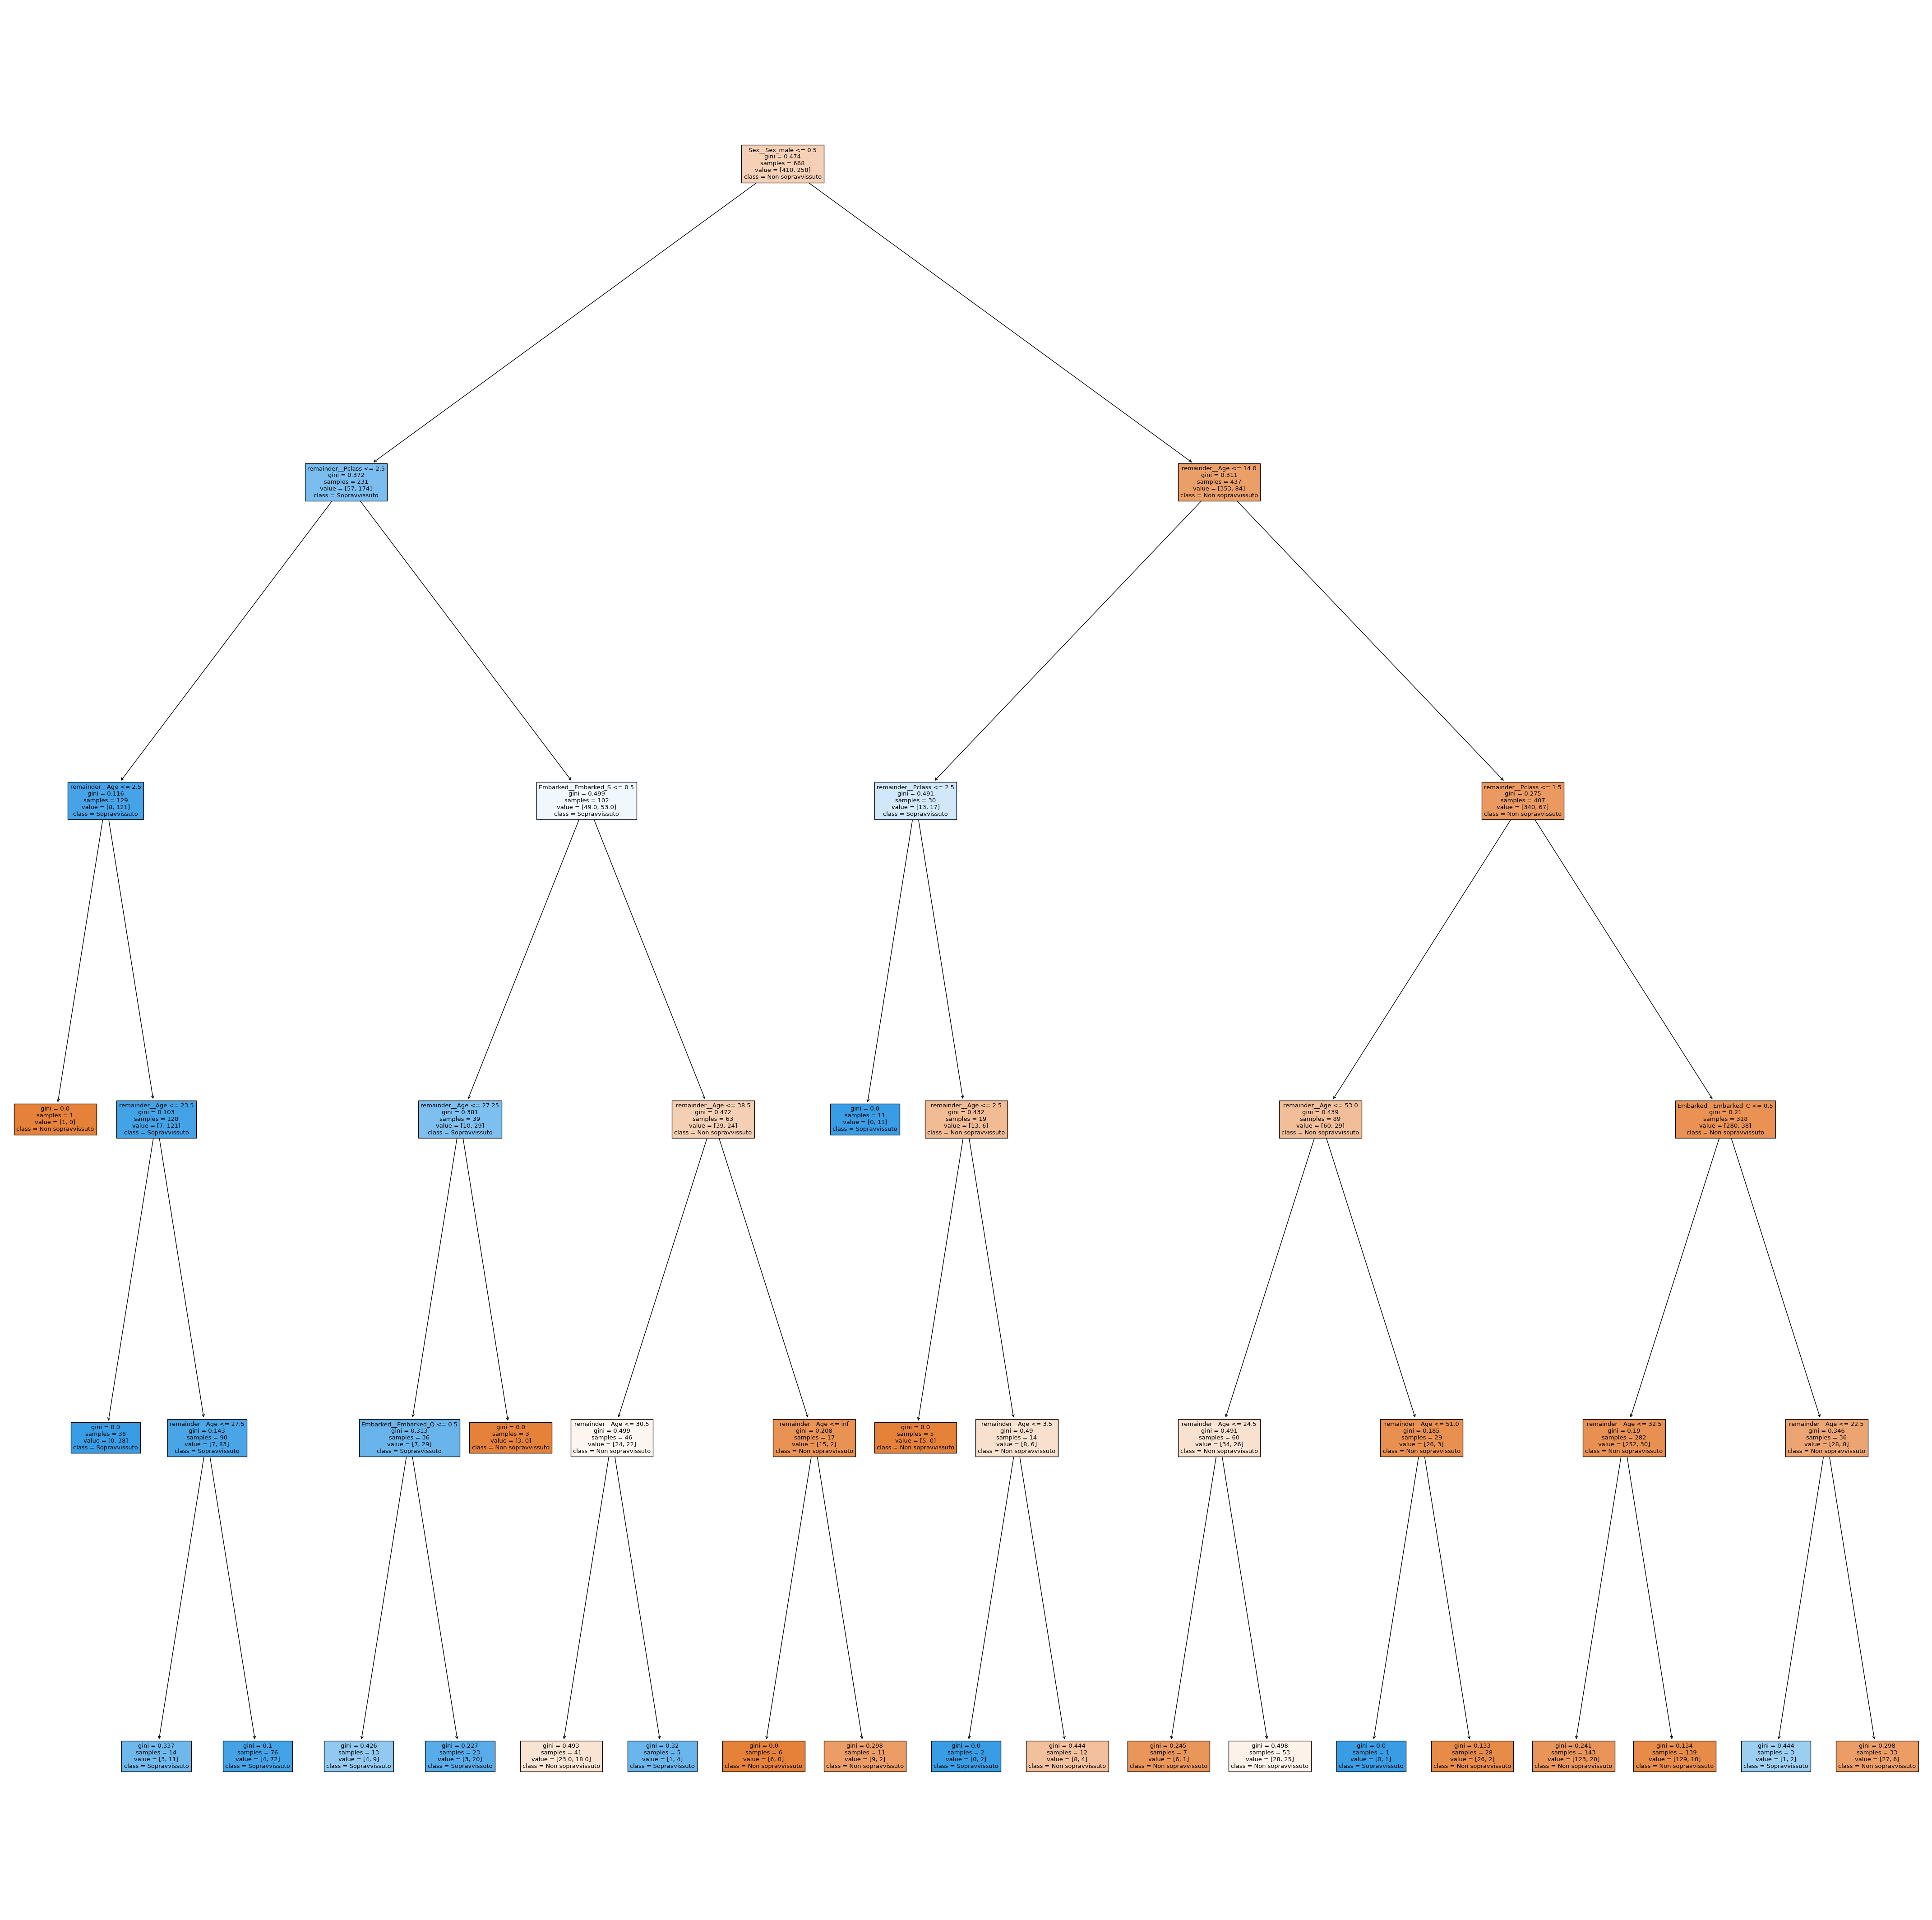

In [123]:
#Visualizzazione dell'albero decisionale
best_preprocessor = best_model.named_steps['preprocessor']

# Get the names of the preprocessed columns
feature_names_list = best_preprocessor.get_feature_names_out()

# Now, you can use this list for plotting
plt.figure(figsize=(55,55))
plot_tree(tree_final,
          feature_names=feature_names_list,
          class_names=["Non sopravvissuto", "Sopravvissuto"],
          filled=True)
plt.show()

# 📌 Considerazioni finali

L'accuratezza del modello finale sul test set è sempre dell'80%. Questo dimostra che il nostro albero decisionale riesce a prevedere bene anche su nuovi dati.<br>Tuttavia, nella raffigurazione dell'albero decisionale, all'ultimo livello di profondità metà dei passeggeri risultano non sopravvissuti.<br><br>Mi sono limitata a usare il modello DecisionTree come richiesto dal progetto, ma è sempre utile provare a usare più tipologie di modelli a seconda del dataset che si ha a disposizione e fare più test per stabilire quale sia il migliore. Una soluzione potrebbe essere l'utilizzo del modello <b>Random Forest</b>: in quanto per sua natura una collezione di decision tree, combina le loro previsioni per ottenere una previsione più robusta e accurata. Essendo composte da più alberi allenati su diversi training set, riescono mediamente a generalizzare di più.
